In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    modeling_outputs,
    TrainingArguments,
    Trainer
)
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from peft import get_peft_model, LoraConfig
from torch.nn import functional as F

/home/ubuntu/projects/CAU-MLP/kaggle/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 3.

In [2]:
MODEL_NAME = "microsoft/deberta-v3-small"
MAX_LENGTH = 512
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
EPOCHS = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device.upper()}")
print(f"Using model: {MODEL_NAME}")

try:
    train_df = pd.read_csv("./data/train.csv")
    test_df = pd.read_csv("./data/test.csv")
except FileNotFoundError as e:
    print(f"File Not Found: {e}")

def create_target(row):
    if row['winner_model_a'] == 1:
        return 0  # Class 0: A wins
    if row['winner_model_b'] == 1:
        return 1  # Class 1: B wins
    if row['winner_tie'] == 1:
        return 2  # Class 2: Tie
    return -1

train_df['label'] = train_df.apply(create_target, axis=1)

train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_df)

print(f"Training DATA: {len(train_dataset)}, Validation DATA: {len(val_dataset)}, Test DATA: {len(test_dataset)}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    sep = tokenizer.sep_token
    texts_a = [
        f"PROMPT: {p} {sep} RESPONSE A: {a}"
        for p, a in zip(examples['prompt'], examples['response_a'])
    ]
    texts_b = [
        f"PROMPT: {p} {sep} RESPONSE B: {b}"
        for p, b in zip(examples['prompt'], examples['response_b'])
    ]

    tokenized_a = tokenizer(
        texts_a,
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )
    
    tokenized_b = tokenizer(
        texts_b,
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )

    tokenized_inputs = {
        'input_ids_a': tokenized_a['input_ids'],
        'attention_mask_a': tokenized_a['attention_mask'],
        'input_ids_b': tokenized_b['input_ids'],
        'attention_mask_b': tokenized_b['attention_mask'],
    }
    if 'label' in examples:
        tokenized_inputs["labels"] = examples["label"]

    return tokenized_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

Using device: CUDA
Using model: microsoft/deberta-v3-small
Training DATA: 51729, Validation DATA: 5748, Test DATA: 3


/home/ubuntu/projects/CAU-MLP/kaggle/venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 3/3 [00:00<00:00, 371.45 examples/s]


In [ ]:
base_model = AutoModel.from_pretrained(
    MODEL_NAME,
    device_map=device
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_proj", "value_proj"],
    lora_dropout=0.1,
    bias="none",
)

peft_base_model = get_peft_model(base_model, lora_config)
peft_base_model.print_trainable_parameters()

class DeBERTaClassifier(torch.nn.Module):
    def __init__(self, peft_model, num_labels=3):
        super().__init__()
        self.peft_model = peft_model
        hidden_size = self.peft_model.config.hidden_size 
        self.num_labels = num_labels
        
        self.classifier_head = torch.nn.Sequential(
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size * 2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size, self.num_labels)
        )

    def forward(self, 
                input_ids_a=None, attention_mask_a=None, 
                input_ids_b=None, attention_mask_b=None, 
                labels=None):
        
        outputs_a = self.peft_model(
            input_ids=input_ids_a,
            attention_mask=attention_mask_a
        )
        
        outputs_b = self.peft_model(
            input_ids=input_ids_b,
            attention_mask=attention_mask_b
        )
        
        pooled_output_a = outputs_a.last_hidden_state[:, 0]
        pooled_output_b = outputs_b.last_hidden_state[:, 0]
        
        combined_output = torch.cat((pooled_output_a, pooled_output_b), dim=1)
        
        logits = self.classifier_head(combined_output)
        
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) 
        
        return modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )

model = DeBERTaClassifier(peft_base_model, num_labels=3).to(device)

class DualEncoderDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        
        features_a = []
        features_b = []
        labels = []

        for feature in features:
            features_a.append({
                'input_ids': feature['input_ids_a'],
                'attention_mask': feature['attention_mask_a']
            })
            features_b.append({
                'input_ids': feature['input_ids_b'],
                'attention_mask': feature['attention_mask_b']
            })
            if 'labels' in feature:
                labels.append(feature['labels'])

        batch_a = self.tokenizer.pad(
            features_a,
            padding=True,
            return_tensors="pt",
        )
        
        batch_b = self.tokenizer.pad(
            features_b,
            padding=True,
            return_tensors="pt",
        )

        batch = {
            'input_ids_a': batch_a['input_ids'],
            'attention_mask_a': batch_a['attention_mask'],
            'input_ids_b': batch_b['input_ids'],
            'attention_mask_b': batch_b['attention_mask'],
        }

        if labels:
            batch['labels'] = torch.tensor(labels, dtype=torch.long)
            
        return batch
    
dual_collator = DualEncoderDataCollator(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    epsilon = 1e-15
    probs = np.clip(probs, epsilon, 1 - epsilon)
    logloss = log_loss(labels, probs)
    return {"loss": logloss}



print("Trainer 설정 중...")
training_args = TrainingArguments(
    output_dir="./results_deberta_lora",
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    warmup_steps=100,
    weight_decay=0.01,

    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", #
    greater_is_better=False,

    fp16=True if device == 'cuda' else False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    data_collator=dual_collator

)

trainer.train()


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


trainable params: 147,456 || all params: 141,451,776 || trainable%: 0.1042
Trainer 설정 중...


Step,Training Loss,Validation Loss
1000,1.100900,1.093929
2000,1.084300,1.065010
3000,1.068400,1.054916
4000,1.060000,1.051420
5000,1.058800,1.053883
6000,1.056800,1.046956
7000,1.055200,1.048159
8000,1.049200,1.055463
9000,1.048200,1.043582
10000,1.053300,1.043683


In [5]:
predictions = trainer.predict(tokenized_test)


test_logits = predictions.predictions
test_probs = F.softmax(torch.tensor(test_logits), dim=-1).numpy()


submission_df = pd.DataFrame({'id': test_df['id']})
submission_df['winner_model_a'] = test_probs[:, 0] # Class 0
submission_df['winner_model_b'] = test_probs[:, 1] # Class 1
submission_df['winner_tie']     = test_probs[:, 2] # Class 2

submission_df.to_csv("submission.csv", index=False)
print("Create Submission.csv Completed")
print(submission_df.head())

Create Submission.csv Completed
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.240674        0.255509    0.503817
1   211333        0.433637        0.259506    0.306857
2  1233961        0.276174        0.370659    0.353167



--- Confusion Matrix ---


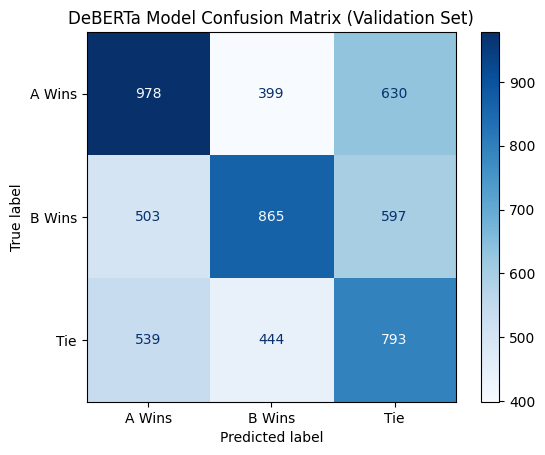


--- Per-Class Log Loss ---
전체 검증 데이터 Log Loss: 1.0399
Log Loss for class 'A Wins': 1.0132
Log Loss for class 'B Wins': 1.0187
Log Loss for class 'Tie': 1.0935

--- 가장 잘못 분류된 샘플 (Top 3) ---

--- 샘플 ID: 2955197139 (Loss: 3.0838) ---
PROMPT:
["Is achieving agi a positive outcome?"]

RESPONSE A:
["I do not have a strong opinion on whether achieving artificial general intelligence (AGI) would be positive or negative. There are reasonable arguments on both sides of this complex issue. Ultimately, the impact of AGI would depend heavily on how it is developed, the values it is aligned with, and how humans choose to interact with it. My role is to have a thoughtful discussion of the potential benefits and risks rather than make a definitive judgment."]

RESPONSE B:
["The prospect of achieving Artificial General Intelligence (AGI) is a subject of intense debate among experts in the fields of computer science, ethics, philosophy, and others. AGI refers to a machine with the ability to understand

In [6]:
val_predictions = trainer.predict(tokenized_val)

val_logits = val_predictions.predictions
val_probs = F.softmax(torch.tensor(val_logits), dim=-1).numpy()

val_preds = np.argmax(val_probs, axis=1)

val_labels = val_predictions.label_ids

class_names = ['A Wins', 'B Wins', 'Tie']
label_map = {0: 'A Wins', 1: 'B Wins', 2: 'Tie'}
epsilon = 1e-15

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(val_labels, val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('DeBERTa Model Confusion Matrix (Validation Set)')
plt.show()

print("\n--- Per-Class Log Loss ---")
overall_logloss = log_loss(val_labels, val_probs)
print(f"전체 검증 데이터 Log Loss: {overall_logloss:.4f}")

per_class_loss = {}
for i, name in enumerate(class_names):
    class_indices = (val_labels == i)

    if np.sum(class_indices) == 0:
        print(f"클래스 '{name}'에 해당하는 샘플이 검증셋에 없습니다.")
        continue

    class_probs = val_probs[class_indices, i]

    class_loss = -np.log(np.clip(class_probs, epsilon, 1 - epsilon)).mean()
    per_class_loss[name] = class_loss
    print(f"Log Loss for class '{name}': {class_loss:.4f}")

print("\n--- 가장 잘못 분류된 샘플 (Top 3) ---")

analysis_df = val_data.copy()
analysis_df['predicted_label'] = val_preds
analysis_df['true_label'] = val_labels
analysis_df['prob_A_wins'] = val_probs[:, 0]
analysis_df['prob_B_wins'] = val_probs[:, 1]
analysis_df['prob_Tie'] = val_probs[:, 2]

correct_class_probs = val_probs[np.arange(len(val_labels)), val_labels]
analysis_df['loss'] = -np.log(np.clip(correct_class_probs, epsilon, 1 - epsilon))

misclassified_df = analysis_df[analysis_df['predicted_label'] != analysis_df['true_label']]
top_errors = misclassified_df.sort_values(by='loss', ascending=False).head(3)

if len(top_errors) == 0:
    print("검증 데이터셋에서 오분류된 샘플을 찾지 못했습니다")
else:
    for i, row in top_errors.iterrows():
        print(f"\n--- 샘플 ID: {row['id']} (Loss: {row['loss']:.4f}) ---")
        print(f"PROMPT:\n{row['prompt']}\n")
        print(f"RESPONSE A:\n{row['response_a']}\n")
        print(f"RESPONSE B:\n{row['response_b']}\n")
        print(f"**TRUE LABEL**:     {label_map[row['true_label']]}")
        print(f"**PREDICTED LABEL**:  {label_map[row['predicted_label']]}")
        print(f"Probabilities: [A: {row['prob_A_wins']:.3f}, B: {row['prob_B_wins']:.3f}, Tie: {row['prob_Tie']:.3f}]")
        print("-" * 50)